In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
import sys
sys.path.append("..")

from dataloaders.dataloader_v1 import get_loader
import torch
from wcmatch.pathlib import Path
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from matplotlib import pyplot as plt
from einops import rearrange, repeat
import cv2
import numpy as np
import random
import time
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio


root = "/hdd_mnt/onurcan/onurk/datasets/"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 24
stage = "train"
dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size, alpha=3)
stage = "val"
val_dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size, alpha=3)
stage = "test"
test_dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size, alpha=3)

In [3]:
# selected_indices_dataloader = list(range(300)) + [random.randrange(len(dataloader.dataset)) for _ in range(300)]
# dataloader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataloader.dataset, selected_indices_dataloader), batch_size=batch_size)
# len(dataloader)

In [3]:
import torch
from utils.utils import zero_padding_twice, fft2d, ifft2d
from utils.algorithms import apply_image_constraint_hio
from models.denoisers import get_denoiser

class End2End(torch.nn.Module):
    def __init__(
        self,
        device: torch.device,
        total_iterations: int = 12,
        total_dc_iterations: int = 5,
        denoiser_architecture: str = "FBPConvNet",
    ):
        super().__init__()

        self.denoiser = get_denoiser(denoiser_architecture)().to(device)

        self.lam = torch.nn.Parameter(
            torch.logspace(-0.11, -1.9, total_iterations).to(device)
        )  # 1....0.125 from the thesis, lam should be [0,1]
        
        self.total_iterations = total_iterations
        self.total_dc_iterations = total_dc_iterations
        self.beta = 0.9
        self.alpha = 3.0

    def forward(self, hio_output, amplitude, support, total_time_steps = None, last_iterations_to_train = 1):
        total_time_steps = total_time_steps or self.total_iterations

        assert total_time_steps <= self.total_iterations, "total_time_steps should be smaller than total_iterations"
        assert last_iterations_to_train <= total_time_steps, "last_iterations_to_train should be smaller than total_time_steps"
            
        x_ = hio_output # B, 10, W, H
        
        self.denoiser.eval()
        with torch.no_grad():
            for i in range(total_time_steps - last_iterations_to_train):
                z_ = self.denoiser(x_ / 255.0, i) * 255.0 # B, 5, W, H
                z_ = torch.clamp(z_, min=0.0, max=255.0)
                
                x_ = self.dc(z_, amplitude, i, support)
                
                if (i == total_time_steps - 1) and (last_iterations_to_train == 0):
                    return [z_]
                
                x_ = torch.cat([x_, z_], dim=1)
                
                x_ = x_ + self.lam[i] * torch.randn_like(x_) * self.alpha * self.alpha

        self.denoiser.train()
        output_list = []
        for i in range(total_time_steps - last_iterations_to_train, total_time_steps):
            z_ = self.denoiser(x_ / 255.0, i) * 255.0
            z_ = torch.clamp(z_, min=0.0, max=255.0)
            
            output_list.append(z_) # normalize(x_)
            
            x_ = self.dc(z_, amplitude, i, support)
            
            output_list.append(x_) # normalize(x_)
            
            x_ = torch.cat([x_, z_], dim=1) # before z_ x_
            
            x_ = x_ + self.lam[i] * torch.randn_like(x_) * self.alpha * self.alpha

        return output_list

    def dc(self, z, b, i, support):
        z_k = zero_padding_twice(z)
        z_0 = z_k
        
        y_new = self.lam[i] * b + (1 - self.lam[i]) * fft2d(z_0).abs()

        for _ in range(self.total_dc_iterations):
            Fz = fft2d(z_k)
            # x_kprime = ifft2d(torch.polar(self.lam[i] * b + (1 - self.lam[i]) * Fz.abs(), Fz.angle())).real
            # x_kprime = self.lam[i] * ifft2d(torch.polar(b, Fz.angle())).real + (1 - self.lam[i]) * z_0
            x_kprime = ifft2d(torch.polar(y_new, Fz.angle())).real
            z_k = apply_image_constraint_hio(x_kprime, z_k, support, beta=self.beta)

        return crop_center_half(z_k)

In [4]:
total_iterations = 18
denoiser_architecture = "UNet2DMulti"

end2end_model = End2End(device=device, total_iterations=total_iterations, denoiser_architecture=denoiser_architecture)
loss = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(end2end_model.parameters(), lr=5e-5, betas=(0.95, 0.999), weight_decay=1e-5)

train

In [6]:
# end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_103.pth"))
# end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_35.pth"))
# end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_best_amax_newwithcorrectsnr.pth"))
# state_dict_old = torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_best_amax_newwithcorrectsnr.pth")
# end2end_model.lam.data = state_dict_old["lam"]
end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_best_amax_newwithcorrectsnr_2__largenew.pth"))

<All keys matched successfully>

In [7]:
import logging
logging.basicConfig(level=logging.INFO, filename="notebooks/py_log_last_epoch_cvat_mololo_3noise_normalized_betterscheduler_clamp_morenoise_moreiterations_notzx_new___yesyesyes_allimages_amax_newwithcorrectsnr_2____largenew_betterdc.log", filemode="w", format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

continue_from_epoch = 0
N_epochs = 40
dataloader_len = len(dataloader)

from diffusers.optimization import get_scheduler
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(dataloader_len * N_epochs) //
    1,
)

min_test_loss = float("inf")

logging.info("epoch (index_dataloader/dataloader_len), loss_value.item(), epoch_losses.mean(), epoch_losses_hio.mean(), total_time_steps, total_time_steps_random_mode")
for epoch in range(continue_from_epoch, N_epochs):
    end2end_model.train()
    
    epoch_losses = np.array([])
    epoch_losses_hio = np.array([])
    
    # for index_dataloader, (im, am, sp, robust_output) in enumerate(dataloader):
    for index_dataloader, (im, am, am_noiseless, sp, robust_output) in enumerate(dataloader):
        im = im.to(device)
        am = am.to(device)
        # am = (torch.flip(am, [2, 3]) + am) / 2 # since, im is real, wrong
        sp = sp.to(device)
        robust_output = robust_output.to(device).float()
        
        total_time_steps_random_mode = min(epoch / (N_epochs * 3/4) * (total_iterations + 3) + 1, total_iterations + 3)
        total_time_steps = int(random.gauss(mu=total_time_steps_random_mode, sigma=3.5))
        total_time_steps = max(total_time_steps, 1)
        total_time_steps = min(total_time_steps, total_iterations)
        
        last_iterations_to_train = 1
        last_iterations_to_train = max(last_iterations_to_train, 1)
        last_iterations_to_train = min(last_iterations_to_train, total_time_steps)
        
        outputs = end2end_model(robust_output, am, sp, total_time_steps=total_time_steps, last_iterations_to_train=last_iterations_to_train)
        target_im = crop_center_half(im).float()
        
        # loss calculation
        final_loss = 0.0
        coefficients = torch.exp(torch.arange(len(outputs)))
        for coefficient, output in zip(coefficients, outputs):
            loss_value = loss(output, target_im)
            final_loss += coefficient * loss_value

        # print(epoch, loss_value.item(), final_loss.item(), loss(target_im, robust_output).item(), total_time_steps, total_time_steps_random_mode)
        final_loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        epoch_losses = np.append(epoch_losses, loss_value.item())
        epoch_losses_hio = np.append(epoch_losses_hio, loss(target_im, robust_output[:, 0:1, :, :]).item())
    
        if (index_dataloader+1) % (dataloader_len // 10) == 0:
            logging.info(f"train: {epoch} ({index_dataloader}/{dataloader_len}), {epoch_losses[-dataloader_len // 10:].mean()}, {epoch_losses.mean()}, {epoch_losses_hio.mean()}, {total_time_steps}, {total_time_steps_random_mode}")

    end2end_model.eval()
    with torch.no_grad():
        def test(dataloader, stage_test_):
            epoch_metrics = {
                "mse_initialization": np.array([]),
                "mse_developed": np.array([]),
                
                "psnr_initialization": np.array([]),
                "psnr_developed": np.array([]),
                
                "ssim_initialization": np.array([]),
                "ssim_developed": np.array([]),
                
                # "time_initialization": np.array([]),
                "time_developed": np.array([]),
            }
            
            # for im, am, sp, robust_output in val_dataloader:
            for index_dataloader, (im, am, am_noiseless, sp, robust_output) in enumerate(dataloader):
                im = im.to(device)
                am = am.to(device)
                sp = sp.to(device)
                robust_output = robust_output.to(device).float()
                
                start_developed = time.time()
                outputs = end2end_model(robust_output, am, sp, total_time_steps=total_iterations, last_iterations_to_train=0)
                output = outputs[-1][:, 0:1, :, :]
                end_developed = time.time()
                
                target_im = crop_center_half(im).float()
                robust_output = robust_output[:, 0:1, :, :]

                # loss calculation
                epoch_metrics["time_developed"] = np.append(epoch_metrics["time_developed"], end_developed - start_developed)
                
                mse_initialization = torch.nn.functional.mse_loss(robust_output, target_im, reduction='none').mean(dim=(1,2,3)).cpu()
                epoch_metrics["mse_initialization"] = np.append(epoch_metrics["mse_initialization"], mse_initialization)
                mse_developed = torch.nn.functional.mse_loss(output, target_im, reduction='none').mean(dim=(1,2,3)).cpu()
                epoch_metrics["mse_developed"] = np.append(epoch_metrics["mse_developed"], mse_developed)
                
                psnr_initialization = peak_signal_noise_ratio(robust_output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
                epoch_metrics["psnr_initialization"] = np.append(epoch_metrics["psnr_initialization"], psnr_initialization)
                psnr_developed = peak_signal_noise_ratio(output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
                epoch_metrics["psnr_developed"] = np.append(epoch_metrics["psnr_developed"], psnr_developed)
                
                ssim_initialization = structural_similarity_index_measure(robust_output, target_im, data_range=255, reduction="none").cpu()
                epoch_metrics["ssim_initialization"] = np.append(epoch_metrics["ssim_initialization"], ssim_initialization)
                ssim_developed = structural_similarity_index_measure(output, target_im, data_range=255, reduction="none").cpu()
                epoch_metrics["ssim_developed"] = np.append(epoch_metrics["ssim_developed"], ssim_developed)
            
            mean_epoch_metrics = {key: np.mean(value) for key, value in epoch_metrics.items()}
            logging.info(f"{stage_test_}: {epoch}, {mean_epoch_metrics}")
            return mean_epoch_metrics
        
        mean_epoch_metrics_val = test(val_dataloader, "val")
        mean_epoch_metrics_test = test(test_dataloader, "test")
        
        if(epoch % 14 == 7):
            torch.save(end2end_model.state_dict(), f"save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_{epoch}_amax_newwithcorrectsnr_2__largenew_betterdc.pth")
        
        if(min_test_loss > mean_epoch_metrics_test["psnr_developed"]):
            min_test_loss = mean_epoch_metrics_test["psnr_developed"]
            torch.save(end2end_model.state_dict(), f"save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_best_amax_newwithcorrectsnr_2__largenew_betterdc.pth")
        
torch.save(end2end_model.state_dict(), "save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_last_amax_newwithcorrectsnr_2__largenew_betterdc.pth")

/home/kuartis/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([24, 1, 256, 256])) that is different to the input size (torch.Size([24, 5, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


inference

In [11]:
end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_last_amax_newwithcorrectsnr_2__largenew_betterdc.pth"))

<All keys matched successfully>

In [13]:
from tqdm import tqdm
import time
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio
import logging
import pickle

filename = "notebooks/py_log_last_epoch_cvat_mololo_3noise_normalized_betterscheduler_clamp_morenoise_moreiterations_notzx_new___testtttyesyesyes_103_allimages_finalll___newwithcorrectsnr2_____largenew_"

In [14]:
test_dataloader = get_loader("noise_amplitude_with_robust_hio_dataset", stage, root, batch_size=1, alpha=3)

In [17]:
logging.basicConfig(level=logging.INFO, filename=f"{filename}.log", filemode="w", format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

end2end_model.eval()
with torch.no_grad():
    # epoch_mean_metrics = []
    all_metrics = []

    for i_montecarlo in range(5):
        epoch_metrics = {
            # "mse_hio": np.array([]),
            # "mse_initialization": np.array([]),
            # "mse_developed": np.array([]),
            
            "psnr_hio": np.array([]),
            "psnr_initialization": np.array([]),
            "psnr_developed": np.array([]),
            
            "ssim_hio": np.array([]),
            "ssim_initialization": np.array([]),
            "ssim_developed": np.array([]),
            
            "time_hio": np.array([]),
            "time_initialization": np.array([]),
            "time_developed": np.array([]),
            
            "psnr_developed_1": np.array([]),
            "ssim_developed_1": np.array([]),
            
            "psnr_developed_2": np.array([]),
            "ssim_developed_2": np.array([]),
            
            "psnr_developed_3": np.array([]),
            "ssim_developed_3": np.array([]),
            
            "psnr_developed_4": np.array([]),
            "ssim_developed_4": np.array([]),
            
            "psnr_developed_mean": np.array([]),
            "ssim_developed_mean": np.array([]),
        }

        test_i = 0
        for im, am, sp, robust_output in tqdm(test_dataloader):
            im = im.to(device)
            am = am.to(device)
            sp = sp.to(device)
            robust_output = robust_output.to(device).float()
            
            # HIO method
            start_hio = time.time()
            
            g, _ = get_algorithm("HIO")(am, sp, use_tqdm=False, iteration=1000)
            im_cropped_normalized = normalize(crop_center_half(im)) # normalize decreases the metrics
            g_cropped_normalized = normalize(crop_center_half(g))
            all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized)
            hio_output = all_mse_loss_corrected[0] * 255
            
            end_hio = time.time()
            
            # Developed algorithm
            start_developed = time.time()
            
            top_k = 10
            g, _ = get_algorithm("MultiOutputRobustHIO")(am, sp, different_random_count=100, top_k=top_k, use_tqdm=False)
            end_time = time.time()
            # print(f"Time: {end_time - start_time}")

            im_cropped_normalized = crop_center_half(im) # normalize decreases the metrics
            g_cropped_normalized = crop_center_half(g)
            
            im_cropped_normalized_repeated = repeat(
                im_cropped_normalized, "b c h w -> b (repeat c) h w", repeat=top_k
            )

            all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized_repeated)
            robust_output = all_mse_loss_corrected[0] # * 255
            robust_output = robust_output.to(device).float()
            
            # clip between 0-255
            robust_output = torch.clip(robust_output, 0, 255)        

            # g, _ = get_algorithm("RobustHIO")(am, sp, use_tqdm=False)
            # im_cropped_normalized = normalize(crop_center_half(im)) # normalize decreases the metrics
            # g_cropped_normalized = normalize(crop_center_half(g))
            # all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized)
            # robust_output = all_mse_loss_corrected[0] * 255
            # robust_output = robust_output.to(device).float()
            
            end_initialization = time.time()

            outputs = end2end_model(robust_output, am, sp, total_time_steps=total_iterations, last_iterations_to_train=0)
            output = outputs[-1][:, 0:1, :, :]
                
            end_developed = time.time()
            
            # measure time
            epoch_metrics["time_hio"] = np.append(epoch_metrics["time_hio"], end_hio - start_hio)
            epoch_metrics["time_initialization"] = np.append(epoch_metrics["time_initialization"], end_initialization - start_developed)
            epoch_metrics["time_developed"] = np.append(epoch_metrics["time_developed"], end_developed - start_developed)
            
            # loss calculation
            target_im = crop_center_half(im).float()
            robust_output = robust_output[:, 0:1, :, :]
                            
            # normalization - makes the metrics worse!
            # target_im = normalize(target_im) * 255
            # hio_output = normalize(hio_output) * 255
            # robust_output = normalize(robust_output) * 255
            # outputs[-1] = normalize(outputs[-1]) * 255
            
            # mse_hio = loss(hio_output, target_im).item()
            # epoch_metrics["mse_hio"] = np.append(epoch_metrics["mse_hio"], mse_hio)
            # mse_initialization = loss(robust_output, target_im).item()
            # epoch_metrics["mse_initialization"] = np.append(epoch_metrics["mse_initialization"], mse_initialization)
            # mse_developed = loss(outputs[-1], target_im).item()
            # epoch_metrics["mse_developed"] = np.append(epoch_metrics["mse_developed"], mse_developed)
            
            psnr_hio = peak_signal_noise_ratio(hio_output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_hio"] = np.append(epoch_metrics["psnr_hio"], psnr_hio)
            psnr_initialization = peak_signal_noise_ratio(robust_output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_initialization"] = np.append(epoch_metrics["psnr_initialization"], psnr_initialization)
            psnr_developed = peak_signal_noise_ratio(output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed"] = np.append(epoch_metrics["psnr_developed"], psnr_developed)
            
            ssim_hio = structural_similarity_index_measure(hio_output, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_hio"] = np.append(epoch_metrics["ssim_hio"], ssim_hio)
            ssim_initialization = structural_similarity_index_measure(robust_output, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_initialization"] = np.append(epoch_metrics["ssim_initialization"], ssim_initialization)
            ssim_developed = structural_similarity_index_measure(output, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed"] = np.append(epoch_metrics["ssim_developed"], ssim_developed)
            
            output_ = outputs[-1][:, 1:2, :, :]
            psnr_developed = peak_signal_noise_ratio(output_, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_1"] = np.append(epoch_metrics["psnr_developed_1"], psnr_developed)
            ssim_developed = structural_similarity_index_measure(output_, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_1"] = np.append(epoch_metrics["ssim_developed_1"], ssim_developed)
            
            output_ = outputs[-1][:, 2:3, :, :]
            psnr_developed = peak_signal_noise_ratio(output_, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_2"] = np.append(epoch_metrics["psnr_developed_2"], psnr_developed)
            ssim_developed = structural_similarity_index_measure(output_, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_2"] = np.append(epoch_metrics["ssim_developed_2"], ssim_developed)
            
            output_ = outputs[-1][:, 3:4, :, :]
            psnr_developed = peak_signal_noise_ratio(output_, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_3"] = np.append(epoch_metrics["psnr_developed_3"], psnr_developed)
            ssim_developed = structural_similarity_index_measure(output_, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_3"] = np.append(epoch_metrics["ssim_developed_3"], ssim_developed)
            
            output_ = outputs[-1][:, 4:5, :, :]
            psnr_developed = peak_signal_noise_ratio(output_, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_4"] = np.append(epoch_metrics["psnr_developed_4"], psnr_developed)
            ssim_developed = structural_similarity_index_measure(output_, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_4"] = np.append(epoch_metrics["ssim_developed_4"], ssim_developed)
            
            output_ = outputs[-1].mean(dim=1, keepdim=True)
            psnr_developed = peak_signal_noise_ratio(output_, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_mean"] = np.append(epoch_metrics["psnr_developed_mean"], psnr_developed)
            ssim_developed = structural_similarity_index_measure(output_, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_mean"] = np.append(epoch_metrics["ssim_developed_mean"], ssim_developed)

            
            # # visualization
            # all_images = rearrange(target_im.cpu(), "b c h w -> b h w c")
            # all_robust_outputs = rearrange(robust_output.cpu(), "b c h w -> b h w c")
            # all_outputs = rearrange(output.detach().cpu(), "b c h w -> b h w c")

            # for plt_output, plt_robust_output, plt_image in zip(all_outputs, all_robust_outputs, all_images):
            #     plt.subplot(1,4,1), plt.imshow(plt_output, cmap="gray"), plt.title("Developed"), plt.axis('off')
            #     plt.subplot(1,4,2), plt.imshow(plt_robust_output, cmap="gray"), plt.title("HIO Stage"), plt.axis('off')
            #     plt.subplot(1,4,3), plt.imshow(plt_image, cmap="gray"), plt.title("GT"), plt.axis('off')
            #     plt.subplot(1,4,4), plt.imshow((plt_output - plt_image).abs(), cmap="gray"), plt.title("Difference"), plt.axis('off')
            #     plt.savefig(f"/hdd_mnt/onurcan/onurk/notebooks/example_test_results_final_largenew/{test_i}_{i_montecarlo}.png", bbox_inches='tight', dpi=300)
            #     test_i += 1
            
        epoch_metrics_mean = {k: v.mean() for k, v in epoch_metrics.items()}
        all_metrics.append(epoch_metrics)
        # epoch_mean_metrics.append(epoch_metrics_mean)
        logging.info(epoch_metrics_mean)
        
    logging.info("Evaluation finished")
    
    # save all_metrics
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(all_metrics, f)
    
    # epoch_mean_metrics = {k: np.array([v[k] for v in epoch_mean_metrics]).mean() for k in epoch_mean_metrics[0].keys()}
    # logging.info(epoch_mean_metrics)

  0%|                                                                                                                                                                                       | 0/236 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [08:28<00:00,  2.16s/it]


compute statistics

In [18]:
# read pickle
all_metrics = pickle.load(open(f"{filename}.pkl", "rb"))

In [19]:
all_image_indices = np.arange(len(all_metrics[0]['psnr_hio']))
unnatural_images_slice = np.arange(114, 120)
natural_images_slice = np.setdiff1d(all_image_indices, unnatural_images_slice)

In [20]:
for i in range(len(all_metrics)):
    print("PSNR")
    print("overall", "natural", "unnatural")
    print(all_metrics[i]['psnr_hio'].mean(), all_metrics[i]['psnr_hio'][natural_images_slice].mean(), all_metrics[i]['psnr_hio'][unnatural_images_slice].mean())
    print(all_metrics[i]['psnr_initialization'].mean(), all_metrics[i]['psnr_initialization'][natural_images_slice].mean(), all_metrics[i]['psnr_initialization'][unnatural_images_slice].mean())
    print(all_metrics[i]['psnr_developed'].mean(), all_metrics[i]['psnr_developed'][natural_images_slice].mean(), all_metrics[i]['psnr_developed'][unnatural_images_slice].mean())
    
    print("")
    
    print("SSIM")
    print("overall", "natural", "unnatural")
    print(all_metrics[i]['ssim_hio'].mean(), all_metrics[i]['ssim_hio'][natural_images_slice].mean(), all_metrics[i]['ssim_hio'][unnatural_images_slice].mean())
    print(all_metrics[i]['ssim_initialization'].mean(), all_metrics[i]['ssim_initialization'][natural_images_slice].mean(), all_metrics[i]['ssim_initialization'][unnatural_images_slice].mean())
    print(all_metrics[i]['ssim_developed'].mean(), all_metrics[i]['ssim_developed'][natural_images_slice].mean(), all_metrics[i]['ssim_developed'][unnatural_images_slice].mean())
        
    print("")
    
    print("TIME")
    print("overall")
    print(all_metrics[i]['time_hio'].mean())
    print(all_metrics[i]['time_initialization'].mean())
    print(all_metrics[i]['time_developed'].mean())
    
    print("=====================================")

PSNR
overall natural unnatural
19.01049218339435 18.981668920102326 20.115383942921955
21.970757468272065 21.963138659104057 22.262811819712322
30.0886831485619 30.198847654591436 25.865710417429607

SSIM
overall natural unnatural
0.43553629002960054 0.43567430642635924 0.43024566148718196
0.4595560323825832 0.45934514072926147 0.467640212426583
0.8584321291517403 0.8614110226216524 0.7442412128051122

TIME
overall
0.32104733333749286
0.9814329713077868
1.6641514281095084
PSNR
overall natural unnatural
18.95308390916404 18.90979803126791 20.612375895182293
22.034696696168286 22.031322172413702 22.164053440093994
30.26407077756979 30.337701739435612 27.441550572713215

SSIM
overall natural unnatural
0.4315196789201286 0.43147387906261114 0.4332753401249647
0.4625527044379358 0.4624398855411488 0.4668774288147688
0.8620972787424669 0.8644137819176135 0.7732979903618494

TIME
overall
0.2960772777007798
0.9682977149042032
1.6186982524597038
PSNR
overall natural unnatural
19.16448938240439 

In [21]:
print("PSNR")
print("overall", "natural", "unnatural")
print("HIO", np.array([v['psnr_hio'].mean() for v in all_metrics]).mean(), np.array([v['psnr_hio'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_hio'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Initialization", np.array([v['psnr_initialization'].mean() for v in all_metrics]).mean(), np.array([v['psnr_initialization'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_initialization'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed", np.array([v['psnr_developed'].mean() for v in all_metrics]).mean(), np.array([v['psnr_developed'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_developed'][unnatural_images_slice].mean() for v in all_metrics]).mean())

print("")
print("SSIM")
print("overall", "natural", "unnatural")
print("HIO", np.array([v['ssim_hio'].mean() for v in all_metrics]).mean(), np.array([v['ssim_hio'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_hio'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Initialization", np.array([v['ssim_initialization'].mean() for v in all_metrics]).mean(), np.array([v['ssim_initialization'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_initialization'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed", np.array([v['ssim_developed'].mean() for v in all_metrics]).mean(), np.array([v['ssim_developed'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_developed'][unnatural_images_slice].mean() for v in all_metrics]).mean())

print("")
print("TIME")
print("overall")
print("HIO", np.array([v['time_hio'].mean() for v in all_metrics]).mean())
print("Initialization", np.array([v['time_initialization'].mean() for v in all_metrics]).mean())
print("Developed", np.array([v['time_developed'].mean() for v in all_metrics]).mean())

PSNR
overall natural unnatural
HIO 19.084934646396313 19.033698884300566 21.04897219340007
Initialization 22.028417297136986 22.025962612317954 22.122513548533124
Developed 30.175641619148898 30.25611826025921 27.090703709920252

SSIM
overall natural unnatural
HIO 0.43602407365342827 0.43582879828370136 0.44350962949295836
Initialization 0.46220488641411067 0.46217359704815825 0.46340431210895383
Developed 0.8601912772756511 0.862783161116683 0.7608357300360997

TIME
overall
HIO 0.29502925852597767
Initialization 0.9755035321591266
Developed 1.62704894603309


graphs

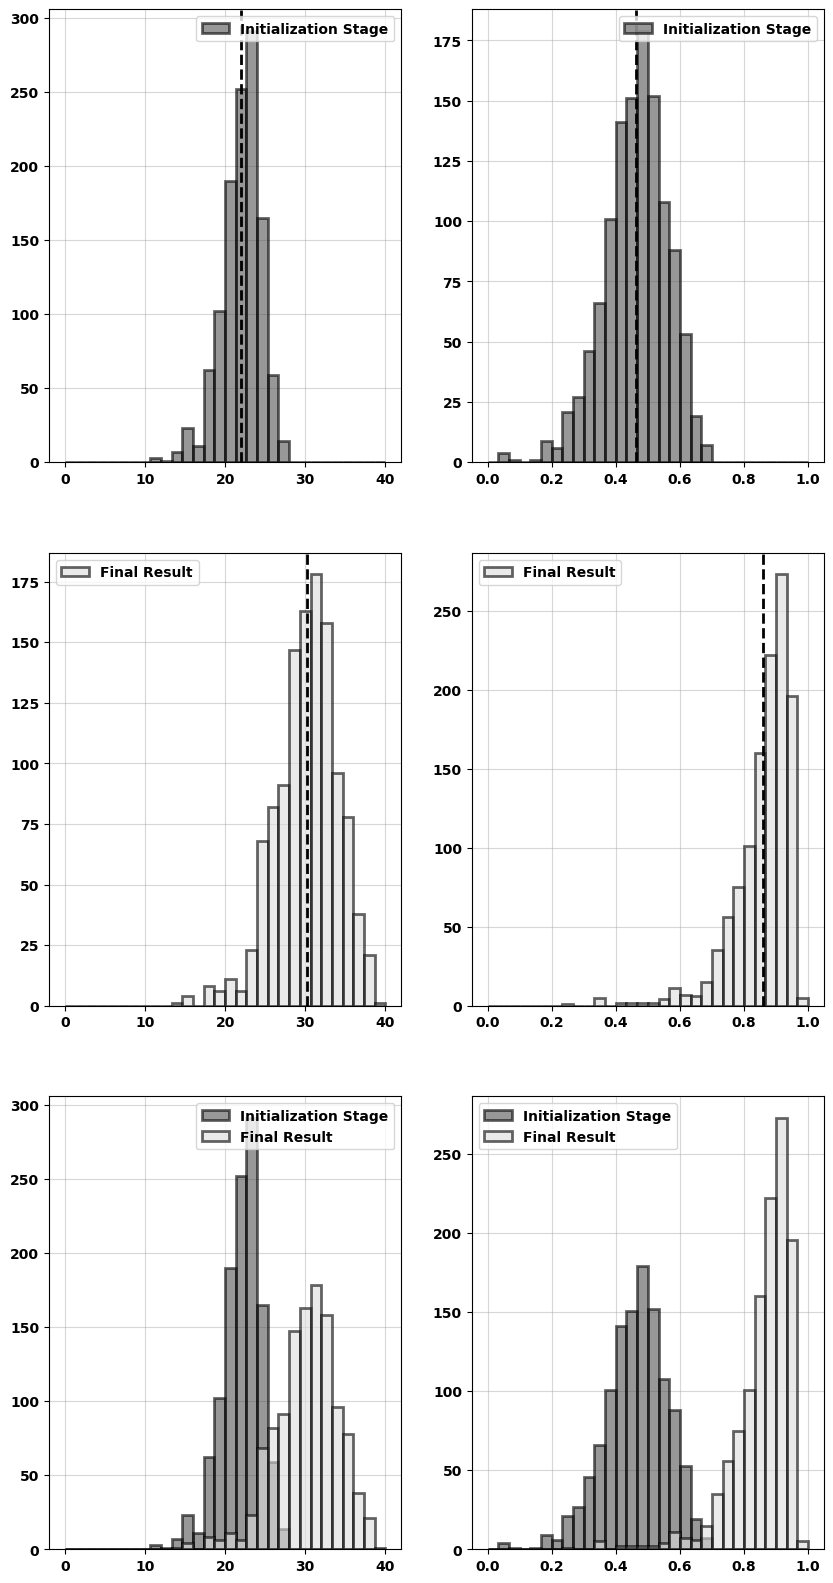

	 	 SSIM 	 || PSNR 	 || time (s)
Initialization Stage: 	 0.4622  || 22.0284 	 || 0.9755
Final Result: 	 0.8602  || 30.1756 	 || 1.6270


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch

psnr_hio       = np.array(np.concatenate([metrics['psnr_initialization'] for metrics in all_metrics]))
ssim_hio       = np.array(np.concatenate([metrics['ssim_initialization'] for metrics in all_metrics]))
psnr_final     = np.array(np.concatenate([metrics['psnr_developed'] for metrics in all_metrics]))
ssim_final     = np.array(np.concatenate([metrics['ssim_developed'] for metrics in all_metrics]))
t_hio          = np.array(np.concatenate([metrics['time_initialization'] for metrics in all_metrics]))
t_final        = np.array(np.concatenate([metrics['time_developed'] for metrics in all_metrics]))

plt.figure(figsize=[10,20])

plt.rcParams.update({'font.weight': 'bold'})
alpha = .6
linewidth = 2
linewidth_mean = 2
bins_psnr = 30
bins_ssim = 30

plt1 = plt.subplot(3,2,1)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_hio, bins=bins_psnr, range=(0,40), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage'])
plt.axvline(psnr_hio.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(3,2,2)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_hio, bins=bins_ssim, range=(0,1), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage'])
plt.axvline(ssim_hio.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(3,2,3)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_final, bins=bins_psnr, range=(0,40), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Final Result'])
plt.axvline(psnr_final.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(3,2,4)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_final, bins=bins_ssim, range=(0,1), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Final Result'])
plt.axvline(ssim_final.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

# all
plt1 = plt.subplot(3,2,5)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_hio, bins=bins_psnr, range=(0,40), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(psnr_final, bins=bins_psnr, range=(0,40), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage','Final Result'])

plt1 = plt.subplot(3,2,6)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_hio, bins=bins_ssim, range=(0,1), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(ssim_final, bins=bins_ssim, range=(0,1), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage','Final Result'])

# save figure as eps
plt.savefig('histogram_alpha3.pdf', format='pdf', dpi=1000)

plt.show()

print('\t \t SSIM \t || PSNR \t || time (s)')
print(f'Initialization Stage: \t {ssim_hio.mean():.4f}  || {psnr_hio.mean():.4f} \t || {t_hio.mean():.4f}')
print(f'Final Result: \t {ssim_final.mean():.4f}  || {psnr_final.mean():.4f} \t || {t_final.mean():.4f}')

prepare dataset for adversarial training

In [ ]:
stage = "train"
test_dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size=1, alpha=3)

save_paths = [str(path).replace("/train/", "/train_outputs_large_alpha_3/") for path in test_dataloader.dataset.gt_image_paths]

end2end_model.eval()
with torch.no_grad():
    for index_dataloader, (im, am, am_noiseless, sp, robust_output) in tqdm(enumerate(test_dataloader)):
        im = im.to(device)
        am = am.to(device)
        sp = sp.to(device)
        # robust_output = robust_output.to(device).float()
        
        top_k = 10
        g, _ = get_algorithm("MultiOutputRobustHIO")(am, sp, different_random_count=100, top_k=top_k, use_tqdm=False)
        end_time = time.time()

        im_cropped_normalized = crop_center_half(im) # normalize decreases the metrics
        g_cropped_normalized = crop_center_half(g)
        
        im_cropped_normalized_repeated = repeat(
            im_cropped_normalized, "b c h w -> b (repeat c) h w", repeat=top_k
        )

        all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized_repeated)
        robust_output = all_mse_loss_corrected[0] # * 255
        robust_output = robust_output.to(device).float()
        robust_output = torch.clip(robust_output, 0, 255)        

        

        outputs = end2end_model(robust_output, am, sp, total_time_steps=total_iterations, last_iterations_to_train=0)
        output = outputs[-1]
        # output = outputs[-1][:, 0:1, :, :]
        
        # save as npy
        output = output.squeeze().cpu().numpy()
        np.save(save_paths[index_dataloader], output)
                
        # target_im = crop_center_half(im).float()
        # robust_output = robust_output[:, 0:1, :, :]


adversarial training

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import sys
sys.path.append("..")

from dataloaders.dataloader_v1 import get_loader
import torch
from wcmatch.pathlib import Path
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from matplotlib import pyplot as plt
from einops import rearrange, repeat
import cv2
import numpy as np
import random
from tqdm import tqdm
from models.denoisers import get_denoiser
import torchvision
import torch.autograd as autograd

In [2]:
root = "/hdd_mnt/onurcan/onurk/datasets/"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 30
stage = "train"
dataloader = get_loader("adversarial_dataset_large", stage, root, batch_size, alpha=3)
stage = "val"
val_dataloader = get_loader("adversarial_dataset_large", stage, root, batch_size, alpha=3)
stage = "test"
test_dataloader = get_loader("adversarial_dataset_large", stage, root, batch_size, alpha=3)

In [3]:
# selected_indices_dataloader = list(range(3000)) + [random.randrange(len(dataloader.dataset)) for _ in range(300)]
# dataloader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataloader.dataset, selected_indices_dataloader), batch_size=batch_size)
# len(dataloader)

In [3]:
class Critic(torch.nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 1)

    def forward(self, x):
        # no torch.nn.functional.sigmoid(
        return self.resnet(x)

In [4]:
adversarial_denoiser = get_denoiser("UNet2DMultiLargeAdversarialNoFreq")().to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(adversarial_denoiser.parameters(), lr=3e-5, betas=(0.95, 0.999), weight_decay=1e-5)

adversarial_train = True

if adversarial_train:
    critic = Critic().to(device)
    critic_optimizer = torch.optim.AdamW(critic.parameters(), lr=3e-5, betas=(0.95, 0.999), weight_decay=1e-5)

In [5]:
adversarial_denoiser.load_state_dict(torch.load("save_adversarial_alpha_3_best_large_new_______.pth"))

<All keys matched successfully>

In [7]:
# train loop
import logging
logging.basicConfig(level=logging.INFO, filename="notebooks/py_log_adversarial_alpha_3_large_new__________.log", filemode="w", format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

continue_from_epoch = 0
N_epochs = 25
dataloader_len = len(dataloader)

from diffusers.optimization import get_scheduler
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=600,
    num_training_steps=(dataloader_len * N_epochs) //
    1,
)

min_test_loss = float("inf")

logging.info("epoch (index_dataloader/dataloader_len), loss_value.item(), epoch_losses.mean()")
for epoch in range(continue_from_epoch, N_epochs):
    adversarial_denoiser.train()
    
    epoch_losses = np.array([])
    epoch_losses_critic = np.array([])
    
    for index_dataloader, (target_im, output) in enumerate(dataloader):
        target_im = target_im.to(device).float()
        output = output.to(device).float()
        
        if adversarial_train:
            # Train critic
            for i in range(3):
                denoised_output = adversarial_denoiser(output / 255.0)[0] * 255.0
                
                real_output = critic(target_im)
                fake_output = critic(denoised_output)

                critic_loss = -torch.mean(real_output) + torch.mean(fake_output)
                
                # Gradient penalty
                lambda_gp = 100.0
                alpha = torch.rand(target_im.size(0), 1, 1, 1).to(device)
                interpolates = (alpha * target_im + (1 - alpha) * denoised_output).requires_grad_(True)
                d_interpolates = critic(interpolates)
                gradients = autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(d_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()        
                critic_loss += lambda_gp * gradient_penalty
                
                critic_loss.backward()
                critic_optimizer.step()
                critic_optimizer.zero_grad()
            
            epoch_losses_critic = np.append(epoch_losses_critic, critic_loss.item())
        
        # Train denoiser
        denoiser_output = adversarial_denoiser(output / 255.0)
        denoised_output = denoiser_output[0] * 255.0
        
        reconstruction_loss = loss(denoised_output, target_im)
        # reconstruction_loss_freq = loss(denoiser_output[1] * 255.0, target_im)
        total_loss = reconstruction_loss # reconstruction_loss_freq
        
        if adversarial_train:
            fake_output = critic(denoised_output)    
            adversarial_loss = -torch.mean(fake_output)
        
            lambda_ = 0.7
            total_loss += lambda_ * adversarial_loss
        
        total_loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        epoch_losses = np.append(epoch_losses, total_loss.item())
        
        if (index_dataloader+1) % (dataloader_len // 130) == 0:
            logging.info(f"train: {epoch} ({index_dataloader}/{dataloader_len}), {total_loss.item()}, {epoch_losses.mean()}")
            if adversarial_train:
                logging.info(f"| {critic_loss.item()}, {epoch_losses_critic.mean()}")
    
    adversarial_denoiser.eval()
    with torch.no_grad():
        def test(dataloader, stage_test_):
            epoch_losses_val = np.array([])
            epoch_losses_old_val = np.array([])
            
            for index_dataloader, (target_im, output) in enumerate(dataloader):
                target_im = target_im.to(device).float()
                output = output.to(device).float()

                denoised_output = adversarial_denoiser(output / 255.0)[0] * 255.0

                # loss calculation
                loss_value = loss(denoised_output, target_im)
                epoch_losses_val = np.append(epoch_losses_val, loss_value.item())
                loss_value_old = loss(output.mean(dim=1, keepdim=True), target_im)
                epoch_losses_old_val = np.append(epoch_losses_old_val, loss_value_old.item())

            logging.info(f"{stage_test_}: {epoch}, {epoch_losses_val.mean()}, {epoch_losses_old_val.mean()}")
            return epoch_losses_val.mean()

        epoch_losses_val = test(val_dataloader, "val")
        epoch_losses_test = test(test_dataloader, "test")
        
        if(epoch % 14 == 7):
            torch.save(adversarial_denoiser.state_dict(), f"save_adversarial_alpha_3_{epoch}_large_new_________.pth")
        
        # save the best model
        if(min_test_loss > epoch_losses_val.mean()):
            min_test_loss = epoch_losses_val.mean()
            torch.save(adversarial_denoiser.state_dict(), "save_adversarial_alpha_3_best_large_new_________.pth")
            
torch.save(adversarial_denoiser.state_dict(), "save_adversarial_alpha_3_last_large_new_________.pth")

inference for prnet-large

In [5]:
adversarial_denoiser = get_denoiser("UNet2DMultiLargeAdversarialNoFreq")().to(device)
adversarial_denoiser.load_state_dict(torch.load("save_adversarial_alpha_3_best_large_new_________.pth"))

<All keys matched successfully>

In [6]:
end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_last_amax_newwithcorrectsnr_2__largenew_betterdc.pth"))

<All keys matched successfully>

In [7]:
from tqdm import tqdm
import time
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio
import logging
import pickle
from einops import reduce

filename = "notebooks/py_log_last_epoch_cvat_mololo_3noise_normalized_betterscheduler_clamp_morenoise_moreiterations_notzx_new___testtttyesyesyes_103_allimages_finalll___newwithcorrectsnr2_____largenew__large_"

In [8]:
test_dataloader = get_loader("noise_amplitude_with_robust_hio_dataset", stage, root, batch_size=1, alpha=3)

In [117]:
logging.basicConfig(level=logging.INFO, filename=f"{filename}.log", filemode="w", format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

end2end_model.eval()
adversarial_denoiser.eval()
with torch.no_grad():
    # epoch_mean_metrics = []
    all_metrics = []

    for i_montecarlo in range(5):
        epoch_metrics = {
            # "mse_hio": np.array([]),
            # "mse_initialization": np.array([]),
            # "mse_developed": np.array([]),
            
            "psnr_hio": np.array([]),
            "psnr_initialization": np.array([]),
            "psnr_developed": np.array([]),
            "psnr_developed_large": np.array([]),
            "psnr_developed_large_tta_0": np.array([]),
            "psnr_developed_large_tta_1": np.array([]),
            "psnr_developed_large_tta_mean": np.array([]),
            
            "ssim_hio": np.array([]),
            "ssim_initialization": np.array([]),
            "ssim_developed": np.array([]),
            "ssim_developed_large": np.array([]),
            "ssim_developed_large_tta_0": np.array([]),
            "ssim_developed_large_tta_1": np.array([]),
            "ssim_developed_large_tta_mean": np.array([]),
            
            "time_hio": np.array([]),
            "time_initialization": np.array([]),
            "time_developed": np.array([]),
            "time_developed_large": np.array([]),
            "time_developed_tta": np.array([]),
        }

        test_i = 0
        for im, am, sp, robust_output in tqdm(test_dataloader):
            im = im.to(device)
            am = am.to(device)
            sp = sp.to(device)
            robust_output = robust_output.to(device).float()
            
            # HIO method
            start_hio = time.time()
            
            g, _ = get_algorithm("HIO")(am, sp, use_tqdm=False, iteration=1000)
            im_cropped_normalized = normalize(crop_center_half(im)) # normalize decreases the metrics
            g_cropped_normalized = normalize(crop_center_half(g))
            all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized)
            hio_output = all_mse_loss_corrected[0] * 255
            
            end_hio = time.time()
            
            # Developed algorithm
            start_developed = time.time()
            
            top_k = 10
            g, _ = get_algorithm("MultiOutputRobustHIO")(am, sp, different_random_count=100, top_k=top_k, use_tqdm=False)
            end_time = time.time()
            # print(f"Time: {end_time - start_time}")

            im_cropped_normalized = crop_center_half(im) # normalize decreases the metrics
            g_cropped_normalized = crop_center_half(g)
            
            im_cropped_normalized_repeated = repeat(
                im_cropped_normalized, "b c h w -> b (repeat c) h w", repeat=top_k
            )

            all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized_repeated)
            robust_output = all_mse_loss_corrected[0] # * 255
            robust_output = robust_output.to(device).float()
            
            # clip between 0-255
            robust_output = torch.clip(robust_output, 0, 255)

            # g, _ = get_algorithm("RobustHIO")(am, sp, use_tqdm=False)
            # im_cropped_normalized = normalize(crop_center_half(im)) # normalize decreases the metrics
            # g_cropped_normalized = normalize(crop_center_half(g))
            # all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized)
            # robust_output = all_mse_loss_corrected[0] * 255
            # robust_output = robust_output.to(device).float()
            
            end_initialization = time.time()

            outputs = end2end_model(robust_output, am, sp, total_time_steps=total_iterations, last_iterations_to_train=0)
            # output = outputs[-1][:, 0:1, :, :]
            output_ = outputs[-1].mean(dim=1, keepdim=True)
                
            end_developed = time.time()
            
            output_large = adversarial_denoiser(outputs[-1] / 255.0)[0] * 255.0
            
            end_developed_large = time.time()
            
            # TTA - only works for batch size 1
            robust_output_augment = repeat(
                robust_output, "b c h w -> (repeat b) c h w", repeat=2
            ).clone()
            robust_output_augment[1:2, :, :, :] = robust_output_augment[1:2, :, :, :].flip((-2,-1))
            am_tta = repeat(am, "b c h w -> (repeat b) c h w", repeat=2).clone()
            sp_tta = repeat(sp, "b c h w -> (repeat b) c h w", repeat=2).clone()

            outputs_tta = end2end_model(robust_output_augment, am_tta, sp_tta, total_time_steps=total_iterations, last_iterations_to_train=0)
            output_tta_ = outputs_tta[-1].mean(dim=1, keepdim=True)
            output_large_tta = adversarial_denoiser(outputs_tta[-1] / 255.0)[0] * 255.0

            output_large_tta[1] = output_large_tta[1].flip((-2,-1))
            output_large_tta_mean = reduce(output_large_tta, "(b 2) c h w -> b c h w", reduction="mean")
            # peak_signal_noise_ratio(output_large_tta_mean, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()

            end_developed_tta = time.time()

            
            # measure time
            epoch_metrics["time_hio"] = np.append(epoch_metrics["time_hio"], end_hio - start_hio)
            epoch_metrics["time_initialization"] = np.append(epoch_metrics["time_initialization"], end_initialization - start_developed)
            epoch_metrics["time_developed"] = np.append(epoch_metrics["time_developed"], end_developed - start_developed)
            epoch_metrics["time_developed_large"] = np.append(epoch_metrics["time_developed_large"], end_developed_large - start_developed)
            epoch_metrics["time_developed_tta"] = np.append(epoch_metrics["time_developed_tta"], end_developed_tta - end_developed_large + end_initialization - start_developed)
            
            # loss calculation
            target_im = crop_center_half(im).float()
            robust_output_ = robust_output[:, 0:1, :, :]
                            
            # normalization - makes the metrics worse!
            # target_im = normalize(target_im) * 255
            # hio_output = normalize(hio_output) * 255
            # robust_output = normalize(robust_output) * 255
            # outputs[-1] = normalize(outputs[-1]) * 255
            
            # mse_hio = loss(hio_output, target_im).item()
            # epoch_metrics["mse_hio"] = np.append(epoch_metrics["mse_hio"], mse_hio)
            # mse_initialization = loss(robust_output, target_im).item()
            # epoch_metrics["mse_initialization"] = np.append(epoch_metrics["mse_initialization"], mse_initialization)
            # mse_developed = loss(outputs[-1], target_im).item()
            # epoch_metrics["mse_developed"] = np.append(epoch_metrics["mse_developed"], mse_developed)
            
            psnr_hio = peak_signal_noise_ratio(hio_output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_hio"] = np.append(epoch_metrics["psnr_hio"], psnr_hio)
            psnr_initialization = peak_signal_noise_ratio(robust_output_, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_initialization"] = np.append(epoch_metrics["psnr_initialization"], psnr_initialization)

            ssim_hio = structural_similarity_index_measure(hio_output, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_hio"] = np.append(epoch_metrics["ssim_hio"], ssim_hio)
            ssim_initialization = structural_similarity_index_measure(robust_output_, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_initialization"] = np.append(epoch_metrics["ssim_initialization"], ssim_initialization)
            
            psnr_developed = peak_signal_noise_ratio(output_, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed"] = np.append(epoch_metrics["psnr_developed"], psnr_developed)
            ssim_developed = structural_similarity_index_measure(output_, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed"] = np.append(epoch_metrics["ssim_developed"], ssim_developed)

            psnr_developed_large = peak_signal_noise_ratio(output_large, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_large"] = np.append(epoch_metrics["psnr_developed_large"], psnr_developed_large)
            ssim_developed_large = structural_similarity_index_measure(output_large, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_large"] = np.append(epoch_metrics["ssim_developed_large"], ssim_developed_large)
            
            psnr_developed_large_tta_0 = peak_signal_noise_ratio(output_large_tta[0:1], target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_large_tta_0"] = np.append(epoch_metrics["psnr_developed_large_tta_0"], psnr_developed_large_tta_0)
            ssim_developed_large_tta_0 = structural_similarity_index_measure(output_large_tta[0:1], target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_large_tta_0"] = np.append(epoch_metrics["ssim_developed_large_tta_0"], ssim_developed_large_tta_0)
            
            psnr_developed_large_tta_1 = peak_signal_noise_ratio(output_large_tta[1:2], target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_large_tta_1"] = np.append(epoch_metrics["psnr_developed_large_tta_1"], psnr_developed_large_tta_1)
            ssim_developed_large_tta_1 = structural_similarity_index_measure(output_large_tta[1:2], target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_large_tta_1"] = np.append(epoch_metrics["ssim_developed_large_tta_1"], ssim_developed_large_tta_1)
            
            psnr_developed_large_tta_mean = peak_signal_noise_ratio(output_large_tta_mean, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_large_tta_mean"] = np.append(epoch_metrics["psnr_developed_large_tta_mean"], psnr_developed_large_tta_mean)
            ssim_developed_large_tta_mean = structural_similarity_index_measure(output_large_tta_mean, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_large_tta_mean"] = np.append(epoch_metrics["ssim_developed_large_tta_mean"], ssim_developed_large_tta_mean)
            
            # # visualization
            # all_images = rearrange(target_im.cpu(), "b c h w -> b h w c")
            # all_robust_outputs = rearrange(robust_output_.cpu(), "b c h w -> b h w c")
            # all_outputs = rearrange(output.detach().cpu(), "b c h w -> b h w c")

            # for plt_output, plt_robust_output, plt_image in zip(all_outputs, all_robust_outputs, all_images):
            #     plt.subplot(1,4,1), plt.imshow(plt_output, cmap="gray"), plt.title("Developed"), plt.axis('off')
            #     plt.subplot(1,4,2), plt.imshow(plt_robust_output, cmap="gray"), plt.title("HIO Stage"), plt.axis('off')
            #     plt.subplot(1,4,3), plt.imshow(plt_image, cmap="gray"), plt.title("GT"), plt.axis('off')
            #     plt.subplot(1,4,4), plt.imshow((plt_output - plt_image).abs(), cmap="gray"), plt.title("Difference"), plt.axis('off')
            #     plt.savefig(f"/hdd_mnt/onurcan/onurk/notebooks/example_test_results_final_largenew/{test_i}_{i_montecarlo}.png", bbox_inches='tight', dpi=300)
            #     test_i += 1
            
        epoch_metrics_mean = {k: v.mean() for k, v in epoch_metrics.items()}
        all_metrics.append(epoch_metrics)
        # epoch_mean_metrics.append(epoch_metrics_mean)
        logging.info(epoch_metrics_mean)
        

    logging.info("Evaluation finished")
    
    # save all_metrics
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(all_metrics, f)
    
    # epoch_mean_metrics = {k: np.array([v[k] for v in epoch_mean_metrics]).mean() for k in epoch_mean_metrics[0].keys()}
    # logging.info(epoch_mean_metrics)

  0%|                                                                                                                                                                                         | 0/236 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [11:15<00:00,  2.86s/it]


analysis

In [118]:
# read pickle
all_metrics = pickle.load(open(f"{filename}.pkl", "rb"))

In [119]:
all_image_indices = np.arange(len(all_metrics[0]['psnr_hio']))
unnatural_images_slice = np.arange(114, 120)
natural_images_slice = np.setdiff1d(all_image_indices, unnatural_images_slice)

In [120]:
for i in range(len(all_metrics)):
    print("PSNR")
    print("overall", "natural", "unnatural")
    print(all_metrics[i]['psnr_hio'].mean(), all_metrics[i]['psnr_hio'][natural_images_slice].mean(), all_metrics[i]['psnr_hio'][unnatural_images_slice].mean())
    print(all_metrics[i]['psnr_initialization'].mean(), all_metrics[i]['psnr_initialization'][natural_images_slice].mean(), all_metrics[i]['psnr_initialization'][unnatural_images_slice].mean())
    print(all_metrics[i]['psnr_developed'].mean(), all_metrics[i]['psnr_developed'][natural_images_slice].mean(), all_metrics[i]['psnr_developed'][unnatural_images_slice].mean())
    
    print("")
    
    print("SSIM")
    print("overall", "natural", "unnatural")
    print(all_metrics[i]['ssim_hio'].mean(), all_metrics[i]['ssim_hio'][natural_images_slice].mean(), all_metrics[i]['ssim_hio'][unnatural_images_slice].mean())
    print(all_metrics[i]['ssim_initialization'].mean(), all_metrics[i]['ssim_initialization'][natural_images_slice].mean(), all_metrics[i]['ssim_initialization'][unnatural_images_slice].mean())
    print(all_metrics[i]['ssim_developed'].mean(), all_metrics[i]['ssim_developed'][natural_images_slice].mean(), all_metrics[i]['ssim_developed'][unnatural_images_slice].mean())
        
    print("")
    
    print("TIME")
    print("overall")
    print(all_metrics[i]['time_hio'].mean())
    print(all_metrics[i]['time_initialization'].mean())
    print(all_metrics[i]['time_developed'].mean())
    
    print("=====================================")

PSNR
overall natural unnatural
19.053576724003936 18.991228203151536 21.44360335667928
21.965799921649996 21.97025425537773 21.795050462086994
30.079051559254275 30.150242067419963 27.3500820795695

SSIM
overall natural unnatural
0.43611252440486925 0.4357963020386903 0.4482343817750613
0.4607746930698217 0.4607458223467288 0.4618814041217168
0.8593859051243734 0.8619941036338391 0.7594049622615179

TIME
overall
0.27147827815201325
0.9193729475393133
1.5046749731241646
PSNR
overall natural unnatural
19.133095632165166 19.072082590020223 21.47192891438802
22.009921599242645 22.002868896981944 22.280275185902912
30.185825129686776 30.27162094116211 26.896985689798992

SSIM
overall natural unnatural
0.43481555265390265 0.43341048333955845 0.4886765430370967
0.460602879776793 0.46043023765087127 0.46722082793712616
0.8595762699842453 0.8623406651227371 0.7536077896753947

TIME
overall
0.2834764456344863
0.9218568832187329
1.5156504784600209
PSNR
overall natural unnatural
18.85355541261576 

In [123]:
print("PSNR")
print("overall", "natural", "unnatural")
print("HIO", np.array([v['psnr_hio'].mean() for v in all_metrics]).mean(), np.array([v['psnr_hio'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_hio'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed Large Initialization", np.array([v['psnr_initialization'].mean() for v in all_metrics]).mean(), np.array([v['psnr_initialization'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_initialization'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed Large Main Loop", np.array([v['psnr_developed'].mean() for v in all_metrics]).mean(), np.array([v['psnr_developed'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_developed'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed Large", np.array([v['psnr_developed_large'].mean() for v in all_metrics]).mean(), np.array([v['psnr_developed_large'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_developed_large'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed Large TTA", np.array([v['psnr_developed_large_tta_mean'].mean() for v in all_metrics]).mean(), np.array([v['psnr_developed_large_tta_mean'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_developed_large_tta_mean'][unnatural_images_slice].mean() for v in all_metrics]).mean())

print("")
print("SSIM")
print("overall", "natural", "unnatural")
print("HIO", np.array([v['ssim_hio'].mean() for v in all_metrics]).mean(), np.array([v['ssim_hio'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_hio'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed Large Initialization", np.array([v['ssim_initialization'].mean() for v in all_metrics]).mean(), np.array([v['ssim_initialization'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_initialization'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed Large Main Loop", np.array([v['ssim_developed'].mean() for v in all_metrics]).mean(), np.array([v['ssim_developed'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_developed'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed Large", np.array([v['ssim_developed_large'].mean() for v in all_metrics]).mean(), np.array([v['ssim_developed_large'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_developed_large'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed Large TTA", np.array([v['ssim_developed_large_tta_mean'].mean() for v in all_metrics]).mean(), np.array([v['ssim_developed_large_tta_mean'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_developed_large_tta_mean'][unnatural_images_slice].mean() for v in all_metrics]).mean())

print("")
print("TIME")
print("overall")
print("HIO", np.array([v['time_hio'].mean() for v in all_metrics]).mean())
print("Developed Large Initialization", np.array([v['time_initialization'].mean() for v in all_metrics]).mean())
print("Developed Large Main Loop", np.array([v['time_developed'].mean() for v in all_metrics]).mean())
print("Developed Large", np.array([v['time_developed_large'].mean() for v in all_metrics]).mean())
print("Developed Large TTA", np.array([v['time_developed_tta'].mean() for v in all_metrics]).mean())

PSNR
overall natural unnatural
HIO 18.977092965578628 18.91528987594273 21.3462114016215
Developed Large Initialization 22.00200123382827 22.00217403411865 21.995377222696938
Developed Large Main Loop 30.174715636948406 30.248764932051948 27.336159324645998
Developed Large 30.21781900858475 30.29480701778246 27.266611989339196
Developed Large TTA 30.501965019258403 30.570486463463823 27.875309658050536

SSIM
overall natural unnatural
HIO 0.433321356097773 0.43272399656150656 0.45622013832132025
Developed Large Initialization 0.46098840014409215 0.4609813943634863 0.4612569550673166
Developed Large Main Loop 0.8600210291854407 0.8626855845295864 0.7578797409931819
Developed Large 0.8630030920950033 0.8656780043114786 0.7604647904634476
Developed Large TTA 0.8683475015527111 0.8712106227356454 0.7585945228735607

TIME
overall
HIO 0.27881510338540805
Developed Large Initialization 0.9208869932061535
Developed Large Main Loop 1.514946734703193
Developed Large 1.555213798102686
Developed La